## Introduction

### Dataset
"Bank Marketing" by \[Moro et al., 2011\].  
Data is related to the phone call based direct marketing campaigns used to access if the bank term deposit (product) would be subscribed.

### Goals
0. Exploratory data analysis.
1. Predict/Classify if the client will subscribe.

## Exploratory Data Analysis (EDA)

In [1]:
import pandas as pd

def read_data(filename):
    data = pd.read_csv(filename, delimiter=';')
    return data.iloc[:, :-1], data['y'].apply(lambda x: 0 if x == "no" else 1)

In [2]:
X, y = read_data('traindata.txt')

numerical_columns = [col for col in X.columns if X[col].dtype in ["int64", "float64"]]
categorical_columns = [col for col in X.columns if X[col].dtype in ["object"]]

### Cursory look

Let's look at some samples.

In [3]:
X.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,42,technician,divorced,secondary,no,-78,yes,yes,cellular,29,jul,10,23,-1,0,unknown
1,50,management,married,tertiary,no,106,yes,no,unknown,15,may,388,2,-1,0,unknown
2,47,admin.,married,secondary,no,407,yes,no,unknown,5,jun,67,12,-1,0,unknown
3,39,admin.,divorced,secondary,no,952,yes,no,unknown,16,jun,62,1,-1,0,unknown
4,30,management,single,tertiary,no,364,no,no,cellular,30,apr,306,2,-1,0,unknown


Now, let's get the shape of the data and data types of the columns.

In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36168 entries, 0 to 36167
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        36168 non-null  int64 
 1   job        36168 non-null  object
 2   marital    36168 non-null  object
 3   education  36168 non-null  object
 4   default    36168 non-null  object
 5   balance    36168 non-null  int64 
 6   housing    36168 non-null  object
 7   loan       36168 non-null  object
 8   contact    36168 non-null  object
 9   day        36168 non-null  int64 
 10  month      36168 non-null  object
 11  duration   36168 non-null  int64 
 12  campaign   36168 non-null  int64 
 13  pdays      36168 non-null  int64 
 14  previous   36168 non-null  int64 
 15  poutcome   36168 non-null  object
dtypes: int64(7), object(9)
memory usage: 4.4+ MB


Marketing calls are annoying.

In [5]:
y.value_counts()

0    31937
1     4231
Name: y, dtype: int64

* Lopsided data: Only 12% belong to class 1 ("yes")
* Imbalanced Classification; Outlier/novelty detection

### Numerical Columns

In [6]:
X[numerical_columns].describe()

,age,balance,day,duration,campaign,pdays,previous
count,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000
mean,40.942076,1365.055989,15.778534,258.363166,2.769907,39.749889,0.579601
std,10.616610,3098.191637,8.313360,257.188052,3.119367,99.547099,2.384831
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1422.250000,21.000000,320.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


#### Remove outliers

Outliers: outside 3rd standard deviation

In [7]:
def remove_outliers(X, y, columns, std_threshold=3):
    outlier_condition = False
    for col in columns:
        mean, std = X[col].mean(), X[col].std()
        lower, higher = mean - std*std_threshold, mean + std*std_threshold
        outlier_condition |= ((X[col] < lower) | (X[col] > higher))
        
    outlier_indices = X[outlier_condition].index
    return X.drop(outlier_indices), y.drop(outlier_indices)

In [8]:
# Only applying to train data, so not including in Pipeline later
X, y = remove_outliers(X, y, numerical_columns)

In [9]:
y.value_counts()

0    28900
1     3238
Name: y, dtype: int64

In [10]:
X[numerical_columns].describe()

,age,balance,day,duration,campaign,pdays,previous
count,32138.000000,32138.000000,32138.000000,32138.000000,32138.000000,32138.000000,32138.000000
mean,40.667154,1087.224936,15.791275,235.804282,2.468417,24.447570,0.346195
std,10.074438,1737.521845,8.352381,190.210357,1.959055,70.329569,1.048357
min,18.000000,-6847.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,66.000000,8.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,430.000000,16.000000,178.000000,2.000000,-1.000000,0.000000
75%,48.000000,1340.000000,21.000000,307.000000,3.000000,-1.000000,0.000000
max,72.000000,10653.000000,31.000000,1029.000000,12.000000,338.000000,7.000000


In [11]:
X[y == 1][numerical_columns].describe()

,age,balance,day,duration,campaign,pdays,previous
count,3238.000000,3238.000000,3238.000000,3238.00000,3238.000000,3238.000000,3238.000000
mean,40.483941,1439.017295,15.024707,441.97097,2.014515,49.342804,0.870908
std,12.170205,1898.239956,8.546408,250.44624,1.512007,82.572857,1.577769
min,18.000000,-3058.000000,1.000000,8.00000,1.000000,-1.000000,0.000000
25%,31.000000,198.000000,8.000000,231.25000,1.000000,-1.000000,0.000000
50%,37.000000,687.000000,15.000000,387.00000,2.000000,-1.000000,0.000000
75%,49.000000,1992.750000,21.000000,630.00000,2.000000,92.000000,1.000000
max,72.000000,10596.000000,31.000000,1029.00000,12.000000,337.000000,7.000000


Comparing metrics when the outcome is "yes"
* Mean duration: 235 vs 442
* Mean balance: 1087 vs 1439

#### Analyzing `day`

Q. Does day-of-the-month `day` matter?  
A. Probably doesn't affect the client. Maybe day-of-the-week might've helped, but we can't deduce that.

Text(0.5, 1.0, 'Contacted vs subscribed')

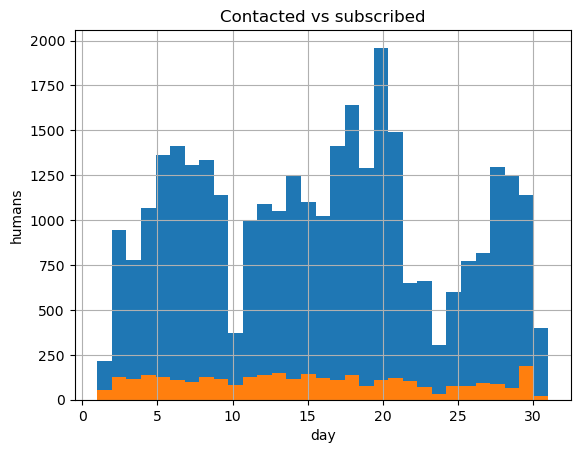

In [12]:
import matplotlib.pyplot as plt

X.day.hist(bins=31)
X[y == 1].day.hist(bins=31)

plt.xlabel('day')
plt.ylabel('humans')
plt.title('Contacted vs subscribed')

#### Dropping columns

Q. So should we drop the column?  
A. 3 ways to handle this:
1. Human intuition.  
    a. Machine sees something humans can't.  
    b. Machine sees something that doesn't make sense.  
3. Leave it to the feature selector.
4. Leave it to the model to select.

In [13]:
def drop_columns(columns):
    for col in columns:
        if col in numerical_columns:
            numerical_columns.remove(col)
        if col in categorical_columns:
            categorical_columns.remove(col)

In [14]:
drop_columns(['day'])

array([<Axes: title={'center': 'age'}>,
       <Axes: title={'center': 'balance'}>,
       <Axes: title={'center': 'duration'}>,
       <Axes: title={'center': 'campaign'}>,
       <Axes: title={'center': 'pdays'}>,
       <Axes: title={'center': 'previous'}>], dtype=object)

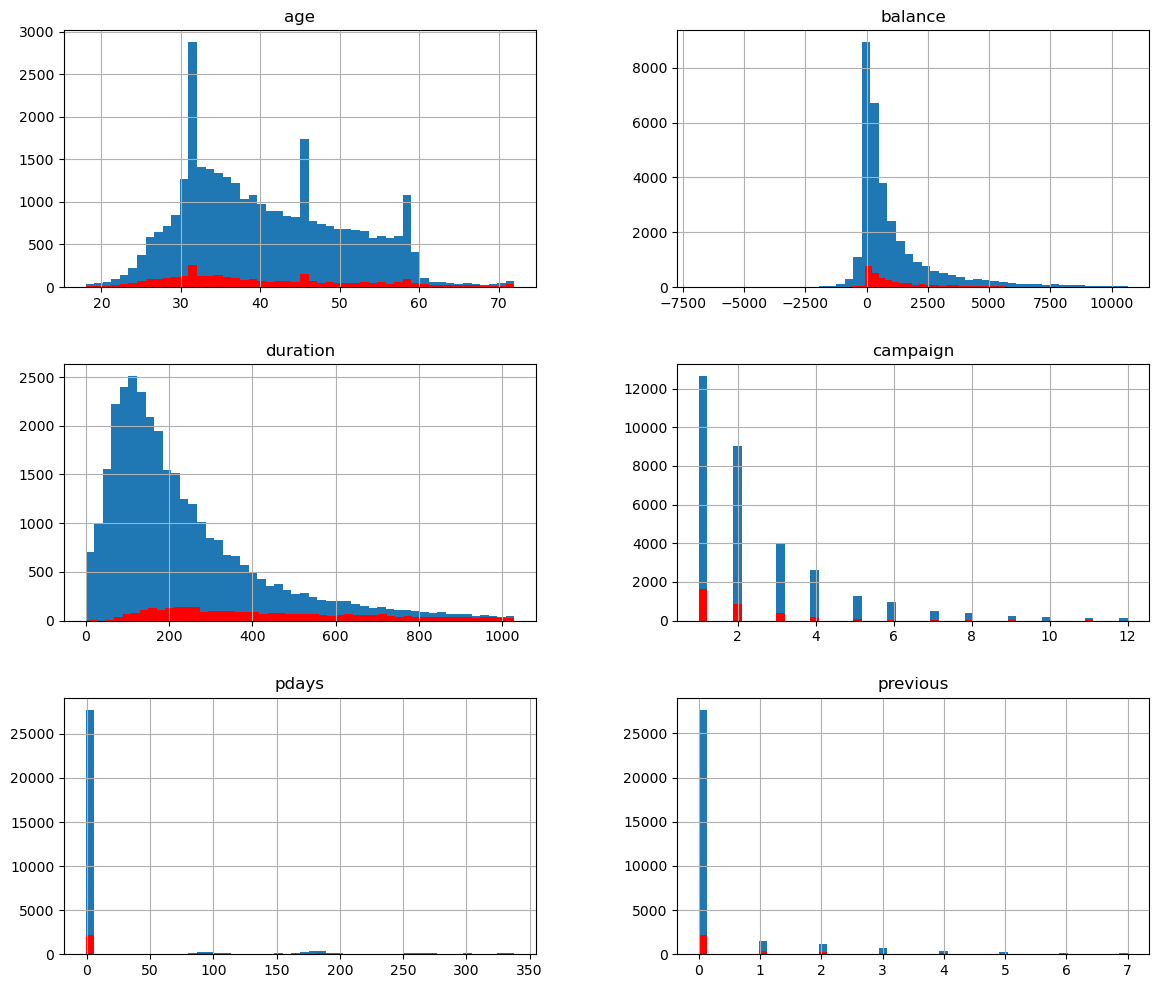

In [15]:
axes = X[numerical_columns].hist(bins=50, figsize=(14, 12))
X[y == 1][numerical_columns].hist(ax=axes.ravel()[:len(numerical_columns)], bins=50,  color='r')

#### Analyzing `pdays`, `previous` and `poutcome`

Most of the clients were not contacted in the previous campaign. Is there a better way to handle this?

Text(0.5, 1.0, 'Contacted vs subscribed')

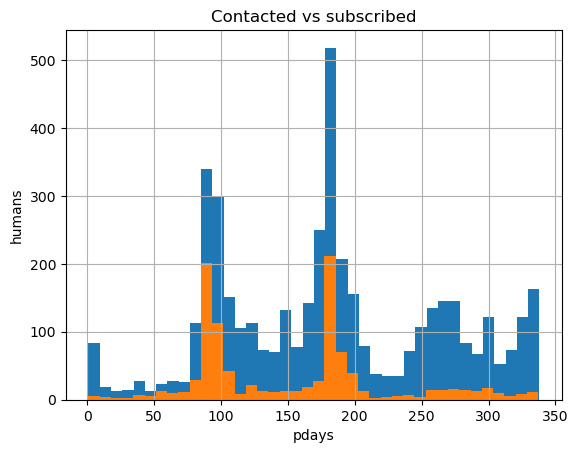

In [16]:
X[X.pdays != -1].pdays.hist(bins=40)
X[y == 1][X[y == 1].pdays != -1].pdays.hist(bins=40)

plt.xlabel('pdays')
plt.ylabel('humans')
plt.title('Contacted vs subscribed')

In [17]:
def discretize_pdays(d):
    return \
        'never' if d == -1 else \
        '1w' if d <= 7 else \
        '1m' if d <= 30 else \
        '6m' if d <= 180 else \
        '1y' if d <= 365 else \
        '2y' if d <= 730 else \
        'old'

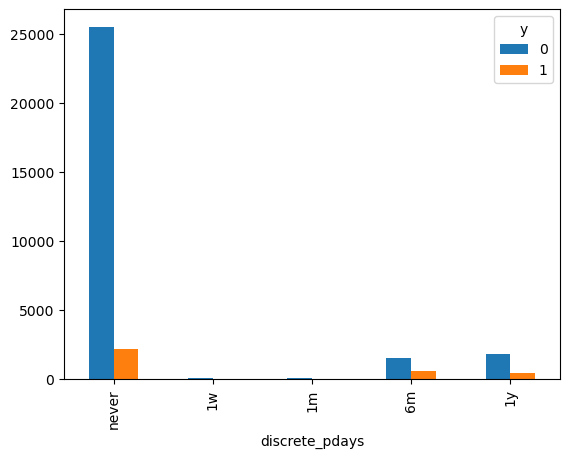

In [18]:
X['discrete_pdays'] = X.pdays.apply(discretize_pdays)

ax = pd.crosstab(X.discrete_pdays, y).loc[['never', '1w', '1m', '6m', '1y']].plot(kind='bar')
#display_percentages(ax)

In [19]:
X = X.drop('discrete_pdays', axis=1)

Text(0.5, 1.0, 'Contacted vs subscribed')

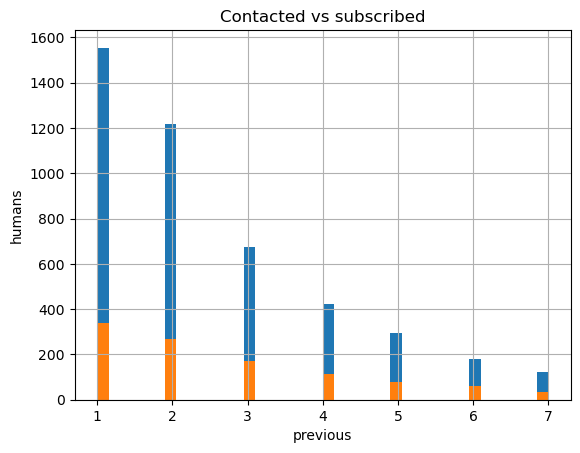

In [20]:
X[X.previous != 0].previous.hist(bins=40)
X[y == 1][X[y == 1].previous != 0].previous.hist(bins=40)

plt.xlabel('previous')
plt.ylabel('humans')
plt.title('Contacted vs subscribed')

In [21]:
X[X.age < 60].shape

(31160, 16)

In [22]:
def display_percentages(ax):
    h = [p.get_height() for p in ax.patches]
    n = len(h)//2
    percent = [h[i]/(h[i] + h[i + n]) for i in range(n)] + [h[i]/(h[i] + h[i - n]) for i in range(n, 2*n)]
    for i, p in enumerate(ax.patches):
        ax.annotate(f"{percent[i]:.0%}", (p.get_x(), p.get_height()*1.01))

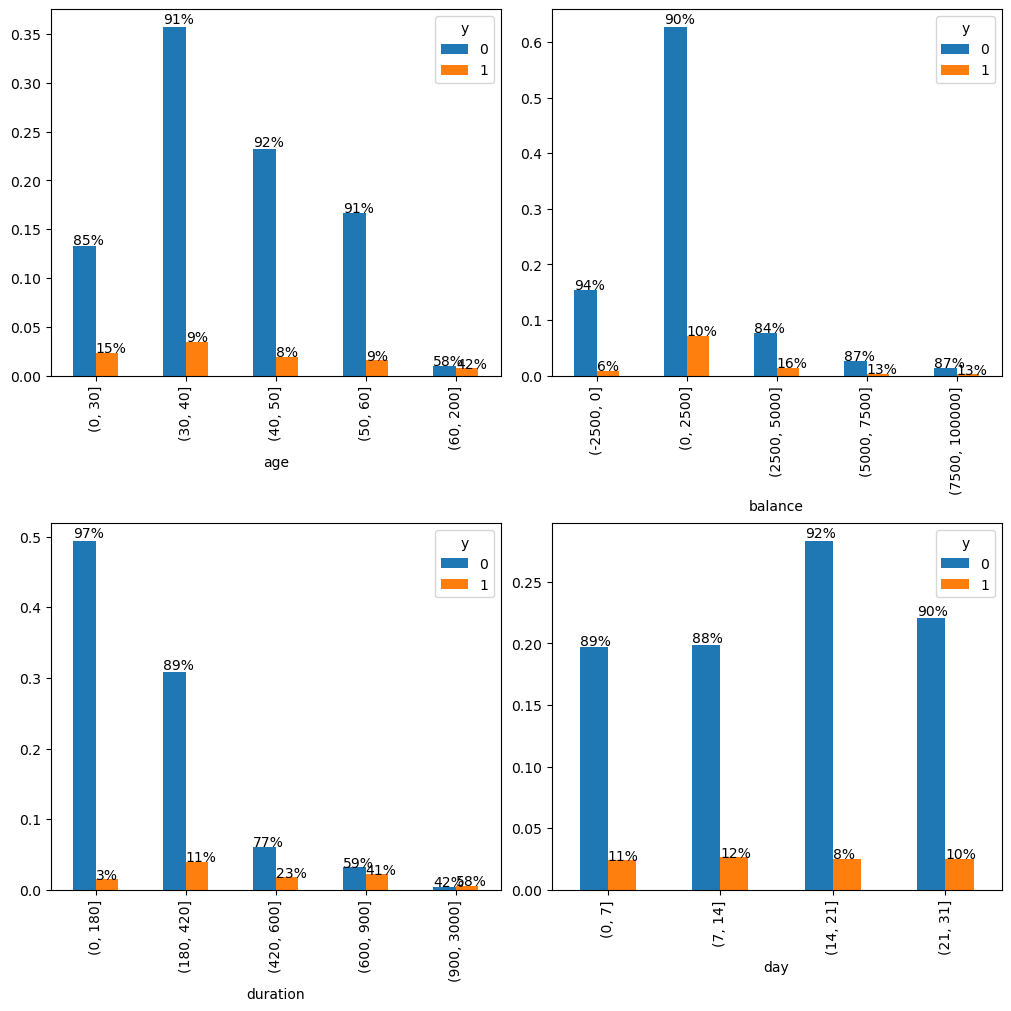

In [23]:
fig, axes = plt.subplots(
    ncols=2, nrows=2,
    figsize=(10, 10),
    constrained_layout=True
)

ax = pd.crosstab(pd.cut(X.age, bins=[0, 30, 40, 50, 60, 200]), y, normalize=True).plot(kind='bar', ax=axes[0, 0])
display_percentages(ax)

ax = pd.crosstab(pd.cut(X.balance, bins=[-2500, 0, 2500, 5000, 7500, 100000]), y, normalize=True).plot(kind='bar', ax=axes[0, 1])
display_percentages(ax)

ax = pd.crosstab(pd.cut(X.duration, bins=[0, 180, 420, 600, 900, 3000]), y, normalize=True).plot(kind='bar', ax=axes[1, 0])
display_percentages(ax)

ax = pd.crosstab(pd.cut(X.day, bins=[0, 7, 14, 21, 31]), y, normalize=True).plot(kind='bar', ax=axes[1, 1])
display_percentages(ax)

#### New feature: `total_contacts`

In [24]:
X['total_contacts'] = X.campaign + X.previous
numerical_columns.append('total_contacts')

### Categorical Columns

In [25]:
X[categorical_columns].describe()

,job,marital,education,default,housing,loan,contact,month,poutcome
count,32138,32138,32138,32138,32138,32138,32138,32138,32138
unique,12,3,4,2,2,2,3,12,4
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown
freq,6919,19427,16574,31537,17652,26887,20418,9522,27671


In [26]:
for col in categorical_columns:
    print(X[col].value_counts(), '\n')

blue-collar      6919
management       6742
technician       5441
admin.           3704
services         2979
retired          1401
self-employed    1143
entrepreneur     1095
unemployed        944
housemaid         897
student           665
unknown           208
Name: job, dtype: int64 

married     19427
single       9054
divorced     3657
Name: marital, dtype: int64 

secondary    16574
tertiary      9442
primary       4811
unknown       1311
Name: education, dtype: int64 

no     31537
yes      601
Name: default, dtype: int64 

yes    17652
no     14486
Name: housing, dtype: int64 

no     26887
yes     5251
Name: loan, dtype: int64 

cellular     20418
unknown       9850
telephone     1870
Name: contact, dtype: int64 

may    9522
jul    5011
aug    4527
jun    3916
nov    2876
apr    2046
feb    1945
jan    1018
oct     459
sep     344
mar     332
dec     142
Name: month, dtype: int64 

unknown    27671
failure     2601
success      950
other        916
Name: poutcome, dtype: int

* `default` is 98% "no", so can drop this column?
* `poutcome` has too many "unknown"s. But this means the client hasn't been contacted before.

#### Analyzing `contact`

Q. Does `contact` matter?  
A. Probably not + 'unknown' is second most common value after 'cellular'.

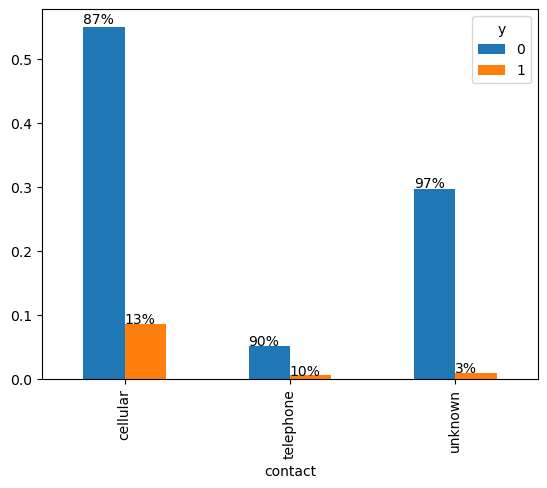

In [27]:
ax = pd.crosstab(X.contact, y, normalize=True).plot(kind='bar')
display_percentages(ax)

In [28]:
drop_columns(['contact'])

#### Unknown values

Replace:
* poutcome: other->failure, unknown->na
* education: unknown->primary

In [29]:
from sklearn.preprocessing import FunctionTransformer

# Since this needs to be done for both train and test,
# it's better to be part of a pipeline.
def cleanup(X):
    #X = X.drop('day', axis=1).drop('contact', axis=1)
    X = X.drop('duration', axis=1)
    X = X.replace({
        # Restricting previous outcome to "success", "failure" and "na".
        "poutcome": {
            "other": "failure",
            "unknown": "na",
        },
        # Set as minimum
        "education": {
            "unknown": "primary",
        },
        "contact": {
            "unknown": "telephone",
        },
    })
    return X

# Make transformer to use in pipeline
data_cleaner = FunctionTransformer(cleanup)

In [30]:
X = data_cleaner.fit_transform(X)

#### New feature: `any_loans`

In [31]:
import numpy as np

X['any_loans'] = np.logical_or(X.housing == "yes", X.loan == "yes")
categorical_columns.append('any_loans')

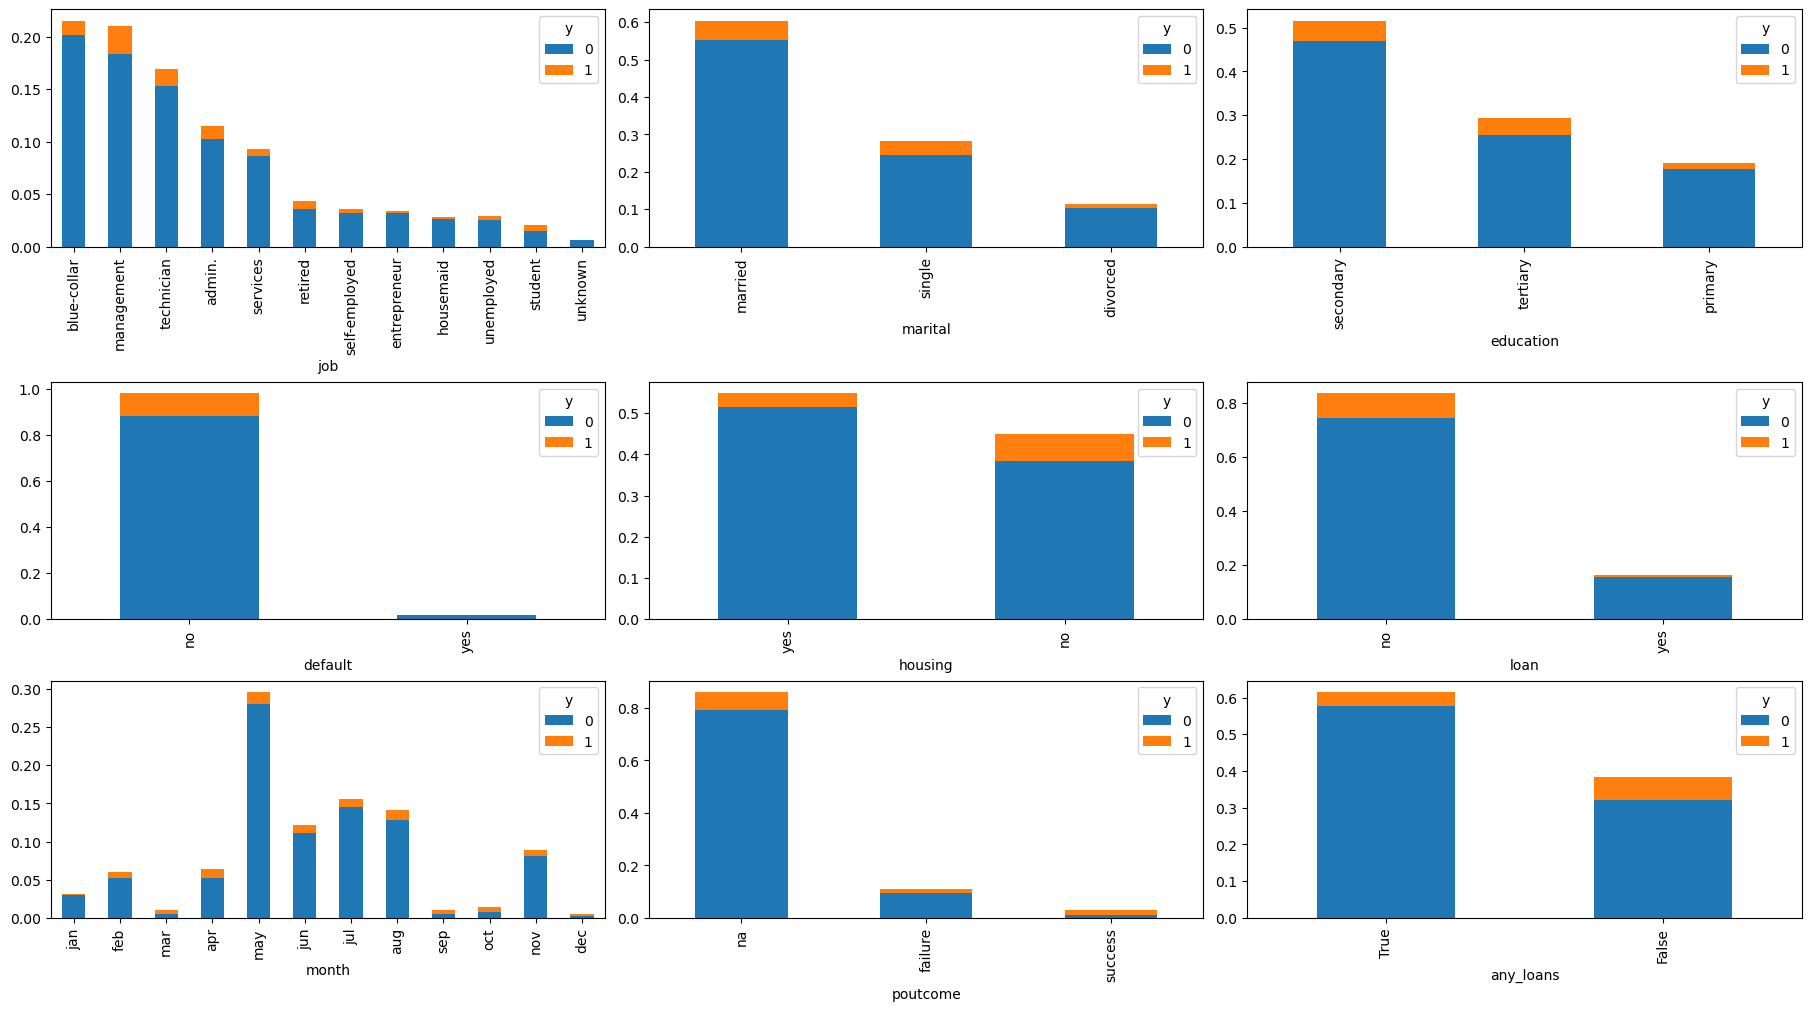

In [32]:
fig, axes = plt.subplots(
    ncols=3,
    nrows=(len(categorical_columns) + 1)//3,
    figsize=(18, 10),
    constrained_layout=True
)
colors = [f'C{i}' for i in range(12)]
for i, col in enumerate(categorical_columns):
    ctab = pd.crosstab(X[col], y, normalize=True)
    if col == 'month':
        months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
        ctab.loc[months].plot(ax=axes[i//3, i%3], kind='bar', stacked=True)
    else:
        ctab.sort_values(by=0, ascending=False).plot(ax=axes[i//3, i%3], kind='bar', stacked=True)

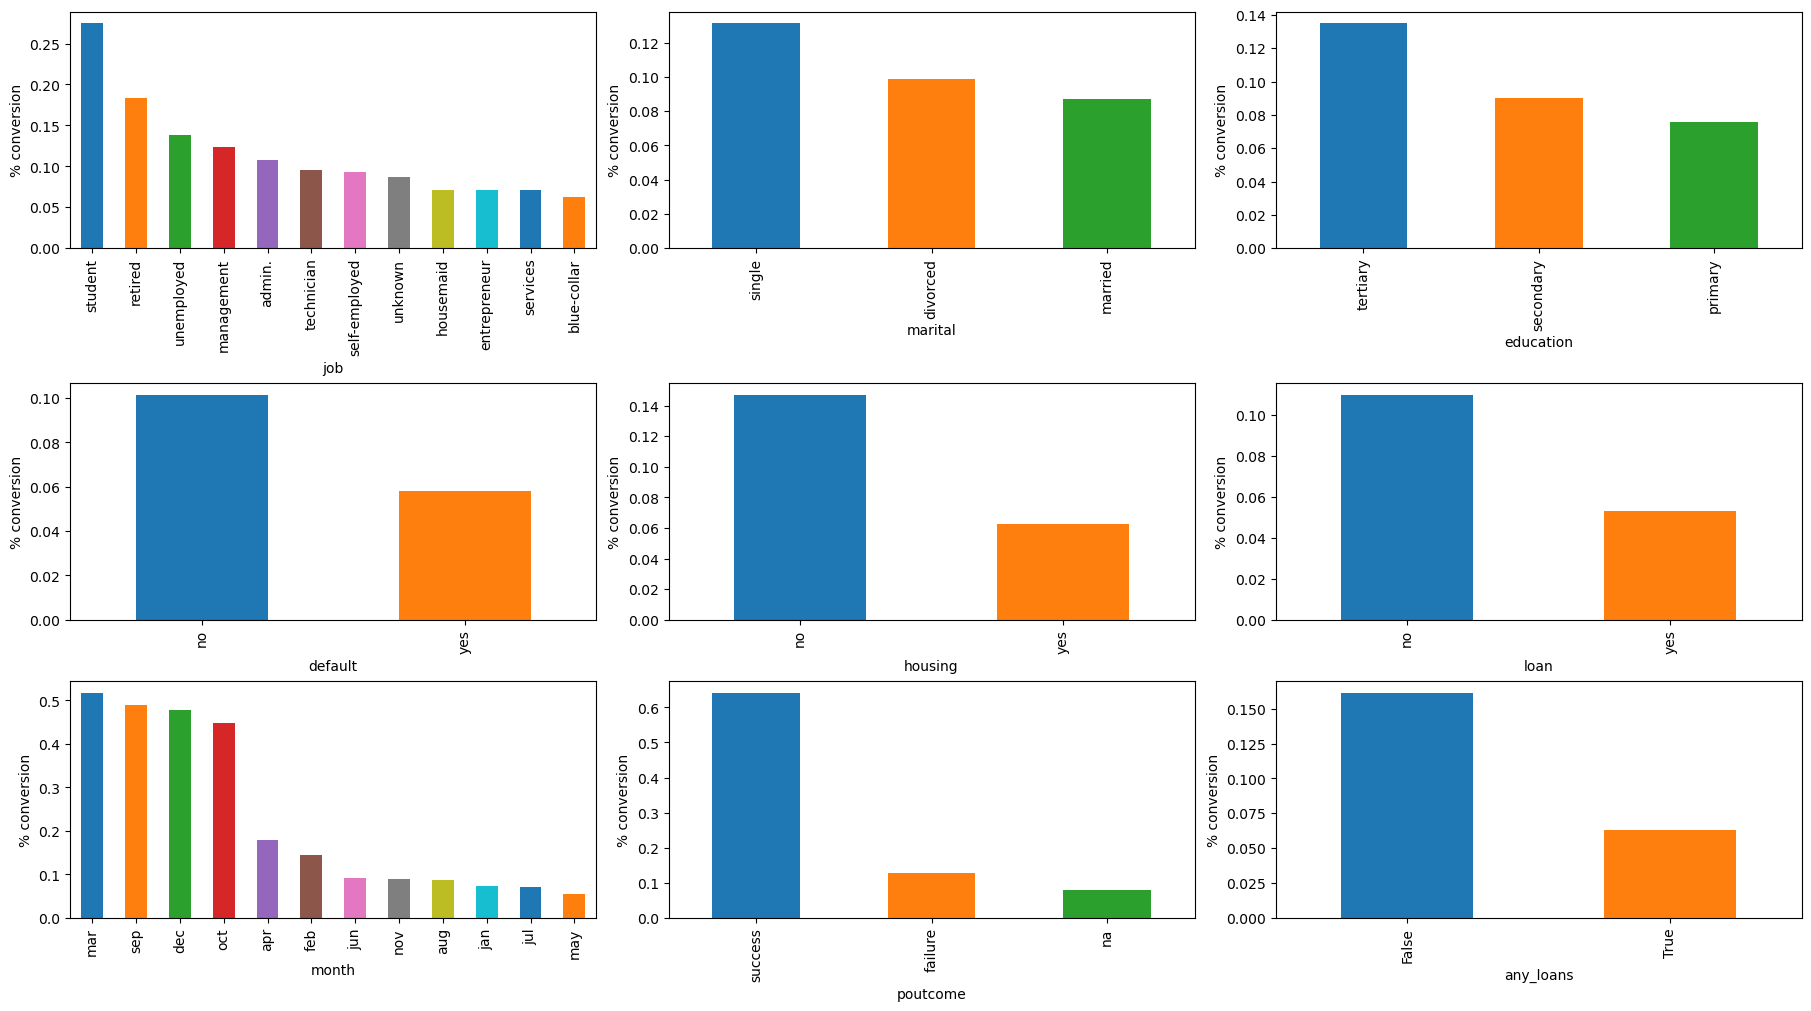

In [33]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(
    ncols=3,
    nrows=(len(categorical_columns) + 1)//3,
    figsize=(18, 10),
    constrained_layout=True
)
colors = [f'C{i}' for i in range(12)]
for i, col in enumerate(categorical_columns):
    (X[y == 1][col].value_counts()/X[col].value_counts())\
        .sort_values(ascending=False)\
        .plot(ax=axes[i//3, i%3], kind='bar', xlabel=col, ylabel='% conversion', color=colors)

### Mutual Information

Text(0.5, 1.0, 'Mutual Information with y')

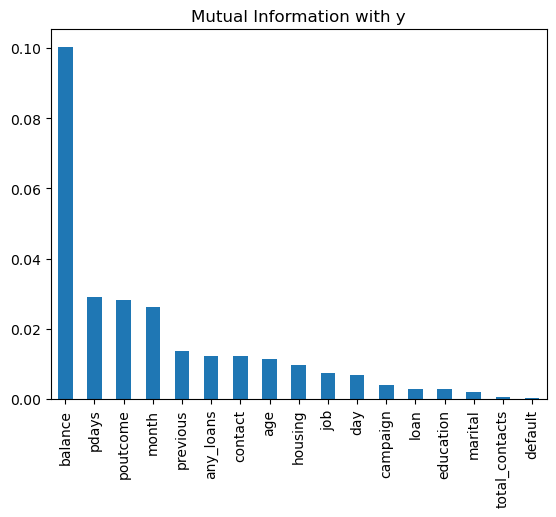

In [34]:
# https://www.kaggle.com/code/ryanholbrook/mutual-information
from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

for col in categorical_columns + ['contact']:
    X[col], _ = X[col].factorize()

make_mi_scores(X, y, X.dtypes == int).plot(kind='bar')
plt.title('Mutual Information with y')

### Correlation matrices

In [35]:
corr = pd.concat([X[[col for col in numerical_columns if col != 'duration']], y], axis=1).corr()
corr.style.background_gradient(cmap='coolwarm')

,age,balance,campaign,pdays,previous,total_contacts,y
age,1.000000,0.094718,0.030857,-0.006390,0.012490,0.034080,-0.006087
balance,0.094718,1.000000,-0.015292,0.044017,0.059948,0.015240,0.067772
campaign,0.030857,-0.015292,1.000000,-0.091138,-0.068173,0.874696,-0.077555
pdays,-0.006390,0.044017,-0.091138,1.000000,0.721053,0.267553,0.118488
previous,0.012490,0.059948,-0.068173,0.721053,1.000000,0.423914,0.167536
total_contacts,0.034080,0.015240,0.874696,0.267553,0.423914,1.000000,0.010984
y,-0.006087,0.067772,-0.077555,0.118488,0.167536,0.010984,1.000000


<Axes: >

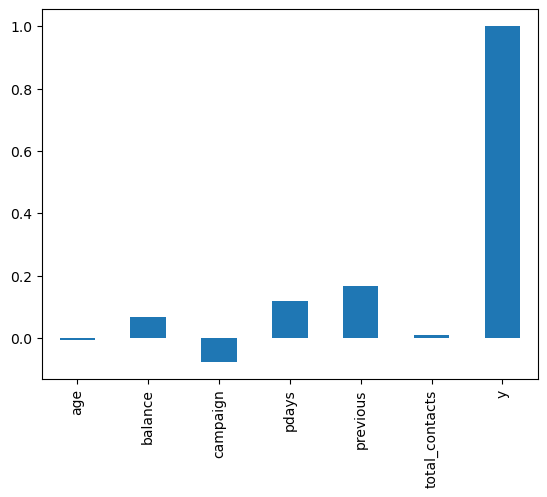

In [36]:
corr['y'].plot(kind='bar')

In [37]:
pd.concat([X[categorical_columns + ['contact']], y], axis=1).corr().style.background_gradient(cmap='coolwarm')

,job,marital,education,default,housing,loan,month,poutcome,any_loans,contact,y
job,1.000000,-0.043622,0.322520,0.014703,0.052587,-0.017024,-0.037787,-0.019977,0.055425,-0.072204,-0.000710
marital,-0.043622,1.000000,-0.154128,0.001554,0.029599,-0.050836,-0.016491,0.022418,0.032531,0.041024,0.064189
education,0.322520,-0.154128,1.000000,0.016049,-0.060658,0.011918,-0.151301,-0.068814,-0.067168,-0.171026,-0.071725
default,0.014703,0.001554,0.016049,1.000000,0.009280,0.070702,-0.016841,-0.038747,-0.031657,-0.012803,-0.019499
housing,0.052587,0.029599,-0.060658,0.009280,1.000000,-0.039893,0.375342,0.018117,0.872365,0.183800,0.139716
loan,-0.017024,-0.050836,0.011918,0.070702,-0.039893,1.000000,-0.025525,-0.031689,-0.349241,0.016072,-0.069915
month,-0.037787,-0.016491,-0.151301,-0.016841,0.375342,-0.025525,1.000000,0.193738,0.350613,0.511925,0.152311
poutcome,-0.019977,0.022418,-0.068814,-0.038747,0.018117,-0.031689,0.193738,1.000000,0.039621,0.235826,0.259882
any_loans,0.055425,0.032531,-0.067168,-0.031657,0.872365,-0.349241,0.350613,0.039621,1.000000,0.157283,0.159631
contact,-0.072204,0.041024,-0.171026,-0.012803,0.183800,0.016072,0.511925,0.235826,0.157283,1.000000,0.147076


### Summary

Data cleanup:
* Remove outliers
* Drop columns: day, contact (opt)

New features:
* discrete_pdays
* total_contacts = campaign + previous
* any_loans = housing or loan

## Preprocessing

In [38]:
X, y = read_data('traindata.txt')

numerical_columns = [col for col in X.columns if X[col].dtype in ["int64", "float64"]]
categorical_columns = [col for col in X.columns if X[col].dtype in ["object"]]

In [39]:
remove_outliers(X, y, numerical_columns)

"""
Drop: day, contact
Replace:
    poutcome: other->failure, unknown->na
    education: unknown->primary
""" 

def new_features(X):
    #X['discrete_pdays'] = X.pdays.apply(discretize_pdays)
    X['total_contacts'] = X.campaign + X.previous
    X['any_loans'] = np.logical_or(X.housing == "yes", X.loan == "yes")
    return X

feature_engineer = FunctionTransformer(new_features)

### Transforming the data

* `data_cleaner`
* `feature_engineer`
* `StandardScaler` on `numerical_columns`
* `OneHotEncoder` on `categorical_columns`
* Combine these into `column_transformer`
* `Normalizer` on samples

In [40]:
from sklearn.compose import ColumnTransformer, make_column_selector

# Need to derive so that we can retain column names
class ColTransformer(ColumnTransformer):
    def fit_transform(self, X, y):
        Xt = super().fit_transform(X, y)
        return pd.DataFrame(Xt, columns=self.get_feature_names_out()) 
        
    def transform(self, X):
        Xt = super().transform(X)
        return pd.DataFrame(Xt, columns=self.get_feature_names_out()) 

In [41]:
# See:
#   https://scikit-learn.org/stable/modules/compose.html#pipeline
#   https://www.kaggle.com/code/alexisbcook/pipelines/tutorial

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, Normalizer

numerical_transformer = Pipeline([
    ('scaler', StandardScaler()),
])

categorical_transformer = Pipeline([
    # If you think about it, OrdinalEncoder for months as we 
    # do IRL, to write our dates, doesn't really make sense:
    # Jan comes before Feb, but doesn't mean Jan < Feb numerically.
    ('onehotencoder', OneHotEncoder(handle_unknown="ignore", sparse_output=False)),

    # Should we scale after OHE, since we are scaling numerical features?
    # If needed (say for PCA), set sparse_output=False in OHE.
    ('scaler', StandardScaler()),
])

column_transformer = ColTransformer([
    ('num', numerical_transformer, make_column_selector(dtype_include=np.number)), 
    ('cat', categorical_transformer, make_column_selector(dtype_include=['object'])),
], verbose_feature_names_out=False)

In [42]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    balanced_accuracy_score,
    f1_score,
    fbeta_score,
    matthews_corrcoef,
)

def score(model, X, y, method='custom', scoring='balanced_accuracy'):
    if method == "cross_val_score":
        return {
            'cv_'+scoring: cross_val_score(
                model, X, y, scoring=scoring, n_jobs=-1,
                cv=StratifiedKFold(shuffle=True, random_state=0)
            ).mean()
        }
        
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0, stratify=y)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    if method == "classification_report":
        return classification_report(y_pred, y_val)
    if method == "confusion_matrix":
        return confusion_matrix(y_val, y_pred)

    return {
        'accuracy': accuracy_score(y_val, y_pred),
        'precision_pos': precision_score(y_val, y_pred),
        'recall_pos': recall_score(y_val, y_pred),
        'f1': f1_score(y_val, y_pred),
        'f1_micro': f1_score(y_val, y_pred, average='micro'),
        'f1_macro': f1_score(y_val, y_pred, average='macro'),
        'f2': fbeta_score(y_val, y_pred, beta=2),
        'mcc': matthews_corrcoef(y_val, y_pred),
        'balanced_accuracy': balanced_accuracy_score(y_val, y_pred),
    }

Now that we have our the basic preprocessing down, let's test out a classifier with default parameters to see how well it does.

In [43]:
from sklearn.ensemble import RandomForestClassifier

model = Pipeline([
    ('cleaner', data_cleaner),
    ('feature_engineer', feature_engineer),
    ('column_transformer', column_transformer),
    ('predictor', RandomForestClassifier(random_state=0))
])
score(model, X, y)

{'accuracy': 0.8911745189117452,
 'precision_pos': 0.5989304812834224,
 'recall_pos': 0.21172022684310018,
 'f1': 0.3128491620111732,
 'f1_micro': 0.8911745189117452,
 'f1_macro': 0.6268785805251639,
 'f2': 0.243161094224924,
 'mcc': 0.31143224677077863,
 'balanced_accuracy': 0.5964663258463998}

It's not great. There are 48 columns after transformation and training data is lopsided, so this is expected.

### Selecting features

See [scikit-learn's feature selection](https://scikit-learn.org/stable/modules/feature_selection.html).

Why feature selection?
* Remove noisy features: avoid overfitting
* Remove interdependent features
* Shorten training time and reduce model size
* Make it easier to visualize

Some models do feature selection as part of the training (yay). Feature selection method that works for one model might not necessarily work for a different kind of model. So, let's explore a few different ways.

In [44]:
Xt = Pipeline([
    ('cleaner', data_cleaner),
    ('feature_engineer', feature_engineer),
    ('column_transformer', column_transformer),
]).fit_transform(X, y)
    
Xt

,age,balance,day,campaign,pdays,previous,total_contacts,job_admin.,job_blue-collar,job_entrepreneur,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_na,poutcome_success
0,0.099649,-0.465780,1.590410,6.485410,-0.409359,-0.243040,5.087686,-0.360657,-0.524536,-0.186205,...,2.364906,-0.367136,-0.103318,-0.662576,-0.309410,-0.128554,-0.11325,-0.416059,0.470046,-0.185886
1,0.853196,-0.406390,-0.093650,-0.246819,-0.409359,-0.243040,-0.349399,-0.360657,-0.524536,-0.186205,...,-0.422850,-0.367136,-0.103318,1.509261,-0.309410,-0.128554,-0.11325,-0.416059,0.470046,-0.185886
2,0.570616,-0.309235,-1.296549,2.959004,-0.409359,-0.243040,2.239689,2.772718,-0.524536,-0.186205,...,-0.422850,2.723783,-0.103318,-0.662576,-0.309410,-0.128554,-0.11325,-0.416059,0.470046,-0.185886
3,-0.182931,-0.133323,0.026640,-0.567401,-0.409359,-0.243040,-0.608308,2.772718,-0.524536,-0.186205,...,-0.422850,2.723783,-0.103318,-0.662576,-0.309410,-0.128554,-0.11325,-0.416059,0.470046,-0.185886
4,-1.030671,-0.323114,1.710700,-0.246819,-0.409359,-0.243040,-0.349399,-0.360657,-0.524536,-0.186205,...,-0.422850,-0.367136,-0.103318,-0.662576,-0.309410,-0.128554,-0.11325,-0.416059,0.470046,-0.185886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36163,-1.030671,-0.039396,-0.334230,-0.567401,1.348628,0.176283,-0.349399,-0.360657,-0.524536,-0.186205,...,-0.422850,-0.367136,-0.103318,-0.662576,3.231961,-0.128554,-0.11325,2.403506,-2.127452,-0.185886
36164,1.795129,-0.385410,0.387510,-0.246819,-0.409359,-0.243040,-0.349399,-0.360657,1.906449,-0.186205,...,-0.422850,-0.367136,-0.103318,1.509261,-0.309410,-0.128554,-0.11325,-0.416059,0.470046,-0.185886
36165,0.005456,-0.529044,1.349830,0.073764,-0.409359,-0.243040,-0.090491,-0.360657,-0.524536,-0.186205,...,-0.422850,-0.367136,-0.103318,1.509261,-0.309410,-0.128554,-0.11325,-0.416059,0.470046,-0.185886
36166,0.382229,-0.407358,1.470120,0.073764,-0.409359,-0.243040,-0.090491,-0.360657,1.906449,-0.186205,...,-0.422850,-0.367136,-0.103318,-0.662576,-0.309410,-0.128554,-0.11325,-0.416059,0.470046,-0.185886


In [45]:
# Need to derive to retain feature names
class FeatureSelector:
    def __init__(self, selector):
        self.selector = selector
        
    def fit(self, X, y=None):
        return self.selector.fit(X, y)
        
    def fit_transform(self, X, y=None):
        Xt = self.selector.fit_transform(X, y)
        return pd.DataFrame(Xt, columns=self.get_feature_names_out()) 
        
    def transform(self, X):
        Xt = self.selector.transform(X)
        return pd.DataFrame(Xt, columns=self.get_feature_names_out())

    def get_feature_names_out(self):
        return self.selector.get_feature_names_out()

**Method 1. Principal Component Analysis**

Dimension reduction and removing dependent columns.

In [46]:
from sklearn.decomposition import PCA

pca_feature_selector = PCA(n_components=0.95)
Xr = pd.DataFrame(pca_feature_selector.fit_transform(Xt))
components = pd.DataFrame(pca_feature_selector.components_, columns=Xt.columns)

len(components)

33

* 95% of the information is contained in 38 columns.
* PCA is usually used on high-dimensional datasets; may not be as useful in our case.
* Difficult to retrieve the column names -> difficult to explain model.

**Method 2. Univariate feature selection**:

Remove features which are not correlated (according to `f_classif`) to the outcome class.

In [47]:
from sklearn.feature_selection import f_classif, SelectPercentile

# f_classif = ANOVA F-value
# chi2 works on frequencies (non-negative)
univariate_feature_selector = SelectPercentile(f_classif, percentile=20)
Xu = FeatureSelector(univariate_feature_selector).fit_transform(Xt, y)
univariate_feature_selector.get_feature_names_out()

array(['pdays', 'housing_no', 'housing_yes', 'contact_cellular',
       'contact_telephone', 'month_mar', 'month_oct', 'month_sep',
       'poutcome_na', 'poutcome_success'], dtype=object)

**Method 3.** Feature selection from model

* Ones that compute feature importance.
* May not be useful if using the same model for prediction.

In [48]:
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

# Feature model can be any which has coef_ or feature_importances_ attribute
# Examples: GradientBoostingClassifier, SVC

# Note: L1 doesn't converge
feature_model = LinearSVC(dual="auto", penalty="l2")
feature_selector = SelectFromModel(feature_model)

Xs = FeatureSelector(feature_selector).fit_transform(Xt, y)
feature_selector.get_feature_names_out()

array(['campaign', 'job_retired', 'housing_no', 'housing_yes',
       'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug',
       'month_dec', 'month_jan', 'month_mar', 'month_nov', 'month_oct',
       'month_sep', 'poutcome_failure', 'poutcome_na', 'poutcome_success'],
      dtype=object)

Great! We were able to reduce to 13 most important columns (`GradientBoostingClassifier` reduces to 10).

**Method 4. Recursive Feature Elimination**

Prune least important features and repeat recursively.

In [49]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import SGDClassifier

# selects half the features by default
rfe_feature_selector = RFE(SGDClassifier(), n_features_to_select=0.2)

rfe_feature_selector = rfe_feature_selector.fit(Xt, y)
rfe_feature_selector.get_feature_names_out()

array(['job_housemaid', 'job_retired', 'default_no', 'default_yes',
       'month_mar', 'month_sep', 'poutcome_failure', 'poutcome_na',
       'poutcome_success'], dtype=object)

Let's see if any of these feature selectors help.

In [50]:
restab = {}
for feature_selector in [
    'passthrough',
    PCA(0.95),
    SelectPercentile(f_classif, percentile=20), 
    SelectFromModel(LinearSVC(dual="auto", penalty="l2")),
    RFE(SGDClassifier()),
]:
    model = Pipeline([
            ('cleaner', data_cleaner),
            ('feature_engineer', 'passthrough'),
            ('column_transformer', column_transformer),
            ('feature_selector',  feature_selector),
            ('predictor', RandomForestClassifier(random_state=0)),
    ])
    restab[str(feature_selector)] = score(model , X, y)
    
pd.DataFrame(restab).T

,accuracy,precision_pos,recall_pos,f1,f1_micro,f1_macro,f2,mcc,balanced_accuracy
passthrough,0.892944,0.618421,0.222117,0.326843,0.892944,0.634345,0.254770,0.326730,0.601978
PCA(n_components=0.95),0.888963,0.563380,0.226843,0.323450,0.888963,0.631484,0.257621,0.308787,0.601773
SelectPercentile(percentile=20),0.884428,0.516796,0.189036,0.276817,0.884428,0.607006,0.216497,0.263003,0.582807
SelectFromModel(estimator=LinearSVC(dual='auto')),0.888188,0.562667,0.199433,0.294487,0.888188,0.616885,0.228999,0.288399,0.589446
RFE(estimator=SGDClassifier()),0.883654,0.506696,0.214556,0.301461,0.883654,0.619002,0.242521,0.276802,0.593438


As we can see, ~we have just wasted n hours of our life that we'll never get back (yay)~ there's not much of an improvement.

### Oversampling

We use [SMOTE](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis#SMOTE) from imblearn's [over_sampling](https://imbalanced-learn.org/dev/references/over_sampling.html#module-imblearn.over_sampling) module for oversampling.

In [51]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(Xt, y)
y_res.value_counts(), y.value_counts()

(0    31937
 1    31937
 Name: y, dtype: int64,
 0    31937
 1     4231
 Name: y, dtype: int64)

Now, we include `SMOTE` in our pre-processing pipeline. Technically, sampling step should not be applied on test data. And, `sklearn.pipeline.Pipeline` doesn't really support samplers, so we use `imblearn.pipeline.Pipeline`.

In [52]:
from imblearn.pipeline import Pipeline as IMBPipeline

# Must use IMBPipeline should you wish to include sampler
model = IMBPipeline([
    ('cleaner', data_cleaner),
    ('feature_engineer', feature_engineer),
    ('column_transformer', column_transformer),
    ('feature_selector', SelectFromModel(estimator=LinearSVC(dual='auto'))),
    ('oversampler', SMOTE(random_state=0)),
    ('predictor', RandomForestClassifier(random_state=0)),
])
score(model, X, y)

{'accuracy': 0.7959522229595223,
 'precision_pos': 0.29234828496042214,
 'recall_pos': 0.5236294896030246,
 'f1': 0.3752116491703353,
 'f1_micro': 0.7959522229595223,
 'f1_macro': 0.6266382745223826,
 'f2': 0.45209727435939284,
 'mcc': 0.28088728857903644,
 'balanced_accuracy': 0.6778342838796686}

We see some improvement in balanced accuracy. This ends the pre-processing stage; let's move on to prediction!

## Models

Checkout [metrics for imbalanced classification](https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification).

* False negatives are costlier than false positives: so not f1 score.
* Recall is more important than precision: so f2 score.
* Balanced accuracy is a generic metric for model comparisons.

### Tree-based models

In [53]:
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.ensemble import (
    EasyEnsembleClassifier,
    RUSBoostClassifier,
    BalancedBaggingClassifier,
)

restab = {}
for oversampler, classifier in [
    (SMOTE(random_state=0), RUSBoostClassifier(random_state=0)),
    ('passthrough', EasyEnsembleClassifier(random_state=0, n_jobs=-1)),
    ('passthrough', BalancedBaggingClassifier(estimator=GradientBoostingClassifier(), n_jobs=-1)),
]:
    model = IMBPipeline([
        ('cleaner', data_cleaner),
        ('feature_engineer', feature_engineer),
        ('column_transformer', column_transformer),
        ('feature_selector', FeatureSelector(SelectFromModel(estimator=GradientBoostingClassifier()))),
        ('oversampler', oversampler),
        ('nomalizer', Normalizer()),
        ('classifier', classifier),
    ])
    restab[str(classifier)] = score(model, X, y, method='cross_val_score')
pd.DataFrame(restab).T

,cv_balanced_accuracy
RUSBoostClassifier(random_state=0),0.701796
"EasyEnsembleClassifier(n_jobs=-1, random_state=0)",0.703900
"BalancedBaggingClassifier(estimator=GradientBoostingClassifier(), n_jobs=-1)",0.712930


Example of GridSearchCV usage to get the best parameters for our model

In [54]:
from sklearn.model_selection import GridSearchCV


parameters = {
    "predictor__max_depth":[3, 5, 8],
    "predictor__max_features": ["log2","sqrt"],
    "predictor__criterion": ["friedman_mse",  "squared_error"],
}

model = IMBPipeline([
    ('cleaner', data_cleaner),
    ('feature_engineer', feature_engineer),
    ('column_transformer', column_transformer),
    ('feature_selector', SelectFromModel(estimator=LinearSVC(dual='auto'))),
    ('oversampler', SMOTE(random_state=0)),
    ('normalizer', Normalizer()),
    ('predictor', GradientBoostingClassifier(random_state=0)),
])

clf = GridSearchCV(model, parameters, cv=2, n_jobs=-1, scoring='balanced_accuracy')
clf.fit(X, y)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('cleaner',
                                        FunctionTransformer(func=<function cleanup at 0x7face5a334c0>)),
                                       ('feature_engineer',
                                        FunctionTransformer(func=<function new_features at 0x7facee103ce0>)),
                                       ('column_transformer',
                                        ColTransformer(transformers=[('num',
                                                                      Pipeline(steps=[('scaler',
                                                                                       StandardScaler())]),
                                                                      <sklearn.compose._column_transformer.make_co...
                                        SelectFromModel(estimator=LinearSVC(dual='auto'))),
                                       ('oversampler', SMOTE(random_state=0)),
                                       ('normalizer', Normalizer()),
                                       ('predictor',
                                        GradientBoostingClassifier(random_state=0))]),
             n_jobs=-1,
             param_grid={'predictor__criterion': ['friedman_mse',
                                                  'squared_error'],
                         'predictor__max_depth': [3, 5, 8],
                         'predictor__max_features': ['log2', 'sqrt']},
             scoring='balanced_accuracy')

In [55]:
clf.best_params_

{'predictor__criterion': 'squared_error',
 'predictor__max_depth': 5,
 'predictor__max_features': 'log2'}

### Linear models and NN

In [56]:
from sklearn.linear_model import *
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold

restab = {}
for classifier in [
    Perceptron(),
    PassiveAggressiveClassifier(),
    SGDClassifier(loss='log_loss'),
    MLPClassifier(solver='sgd', max_iter=300),
]:
    model = IMBPipeline([
        ('cleaner', data_cleaner),
        ('feature_engineer', feature_engineer),
        ('column_transformer', column_transformer),
        ('feature_selector', SelectFromModel(estimator=SGDClassifier(loss='log_loss'))),
        ('oversampler', SMOTE(random_state=0)),
        ('normalizer', Normalizer()),
        ('classifier', classifier),
    ])
    restab[str(classifier)] = score(model, X, y, method='cross_val_score')
pd.DataFrame(restab).T

,cv_balanced_accuracy
Perceptron(),0.604831
PassiveAggressiveClassifier(),0.623601
SGDClassifier(loss='log_loss'),0.674319
"MLPClassifier(max_iter=300, solver='sgd')",0.679621


## External data

Download from https://archive.ics.uci.edu/dataset/222/bank+marketing; very close to the dataset we have
* No balance
* Day-of-the-week instead of day-of-the-month
* Slightly different categorical values
* New features: emp.var.rate, cons.price.idx, cons.conf.idx, cons.conf.idx, nr.employed
* More samples

---

Re usage:

* In short, there's no easy way to map 1-1 from old dataset to this new dataset.
* This means that we can use the dataset to see if there's an improvement in cross validation scores of our models,
* but we won't be able to use the new dataset to predict the existing test set. 
* 15y ago and the link returns 404, so we can't try to get the new data from the source directly.

To test your model using external data, simply replace 'traindata.txt' with 'bank-additional-full.csv'.

## Performance on test set

We consider 2 of the best models: MLPClassifer and BalancedBagging with GradientBoostingClassifier

In [57]:
X_test, y_test = read_data('testdata.txt')

def metric_report(y_test, y_pred):
    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision_pos': precision_score(y_test, y_pred),
        'recall_pos': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'f1_micro': f1_score(y_test, y_pred, average='micro'),
        'f1_macro': f1_score(y_test, y_pred, average='macro'),
        'f2': fbeta_score(y_test, y_pred, beta=2),
        'mcc': matthews_corrcoef(y_test, y_pred),
        'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
    }

In [58]:
res = {}
for oversampler, classifier in [
    (SMOTE(random_state=0), MLPClassifier(solver='sgd', max_iter=300)),
    ('passthrough', BalancedBaggingClassifier(
        GradientBoostingClassifier(
            random_state=0,
            max_depth=5,
            max_features='log2',
            criterion="squared_error"))),
]:
    model = IMBPipeline([
        ('cleaner', data_cleaner),
        ('feature_engineer', feature_engineer),
        ('column_transformer', column_transformer),
        ('feature_selector', SelectFromModel(estimator=GradientBoostingClassifier())),
        ('oversampler', oversampler),
        ('normalizer', Normalizer()),
        ('classifier', classifier),
    ])
    model.fit(X, y)
    y_pred = model.predict(X_test)
    res[str(classifier)] = metric_report(y_test, y_pred)
pd.DataFrame(res).T

,accuracy,precision_pos,recall_pos,f1,f1_micro,f1_macro,f2,mcc,balanced_accuracy
"MLPClassifier(max_iter=300, solver='sgd')",0.800951,0.316337,0.603970,0.415205,0.800951,0.647634,0.511036,0.332614,0.71551
"BalancedBaggingClassifier(estimator=GradientBoostingClassifier(criterion='squared_error',\n max_depth=5,\n max_features='log2',\n random_state=0))",0.805595,0.323944,0.608696,0.422850,0.805595,0.652981,0.517685,0.341784,0.72019
